In [5]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import rioxarray

from levee_hunter.utils import find_splits, interactive_labeling
from levee_hunter.get_mask import get_mask
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.plots import plot_img_and_target


from torch.utils.data import DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
from levee_hunter.plots import infer_and_visualize
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Importing the Lidar data (.tif files)
data_dir = "../data/raw/w3-Lidar"
data_dir2 = "../data/raw/w4-Lidar/13_resolution"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
tif_files2 = [file for file in os.listdir(data_dir2) if file.endswith(".tif")]

images = [
    rioxarray.open_rasterio(os.path.join(data_dir2, file)) for file in tif_files2[:]
]

images = images + [rioxarray.open_rasterio(os.path.join(data_dir, tif_files[1]))]

len(images)

5

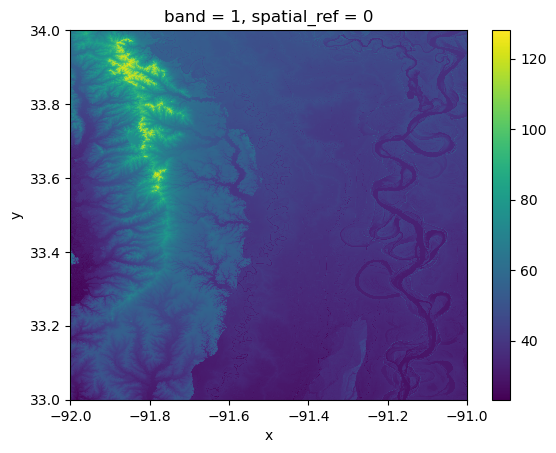

In [7]:
images[0].plot()

In [8]:
for img in images:
    print(img.rio.crs)

EPSG:4269
EPSG:4269
EPSG:4269
EPSG:4269
EPSG:4269


In [9]:
for img in images:
    print(img.shape)

(1, 10812, 10812)
(1, 10812, 10812)
(1, 10812, 10812)
(1, 10812, 10812)
(1, 10812, 10812)


In [10]:
levees_file = "../data/raw/w3-Levees/levees.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_4269_full = levees_data.to_crs("EPSG:4269")

/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


<Axes: >

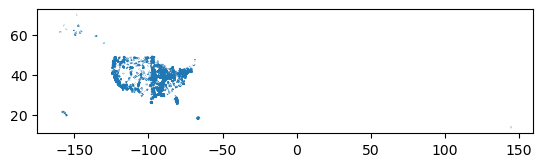

In [11]:
levees_data_4269_full.plot()

In [12]:
# Now get masks for all images:
lidar_images_arr = []
targets_arr = []
for image in images:
    lidar_data, target = get_mask(image, levees_data_4269_full, invert=True)
    lidar_data = lidar_data.reshape(lidar_data.shape[1], lidar_data.shape[2])
    lidar_images_arr.append(lidar_data)
    targets_arr.append(target)

lidar_images_arr = np.array(lidar_images_arr)
targets_arr = np.array(targets_arr)

lidar_images_arr.shape

(5, 10812, 10812)

0


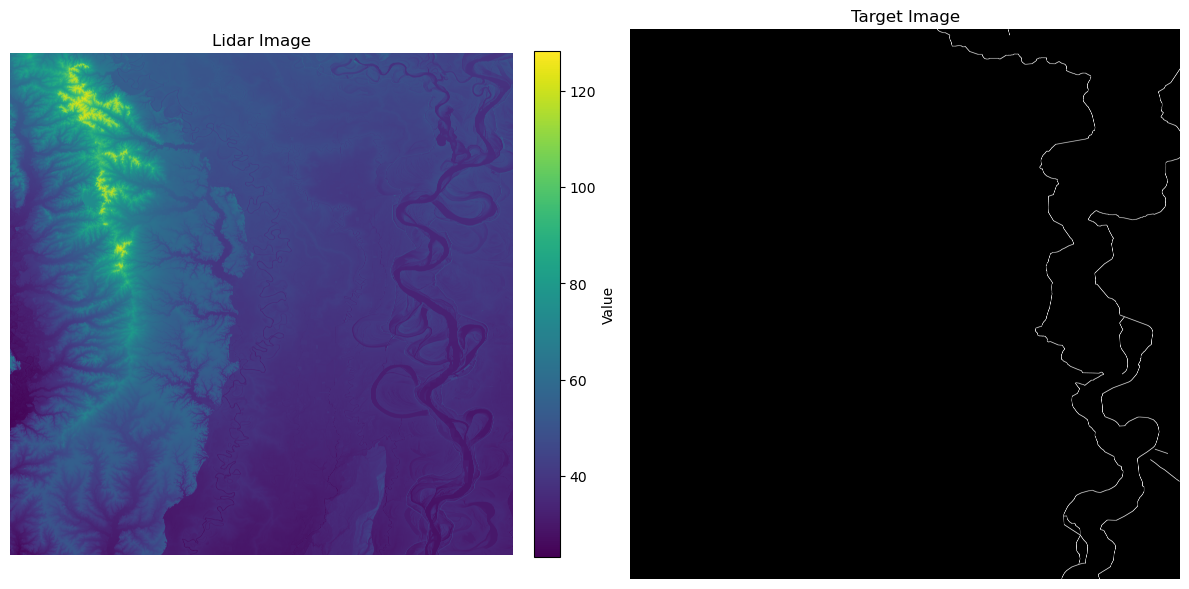

1


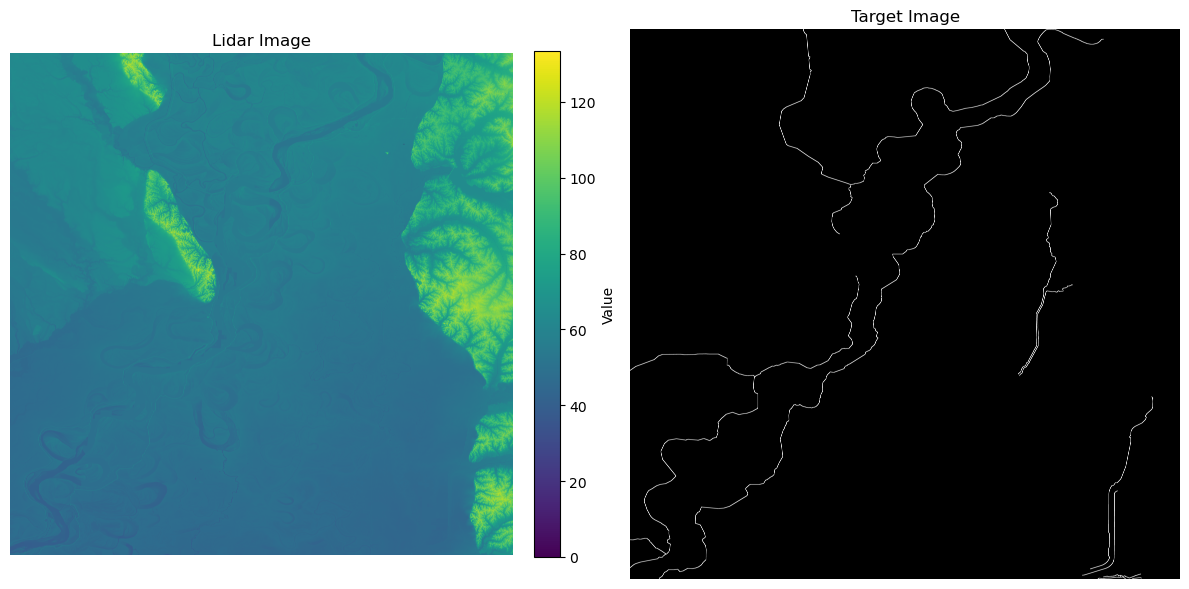

2


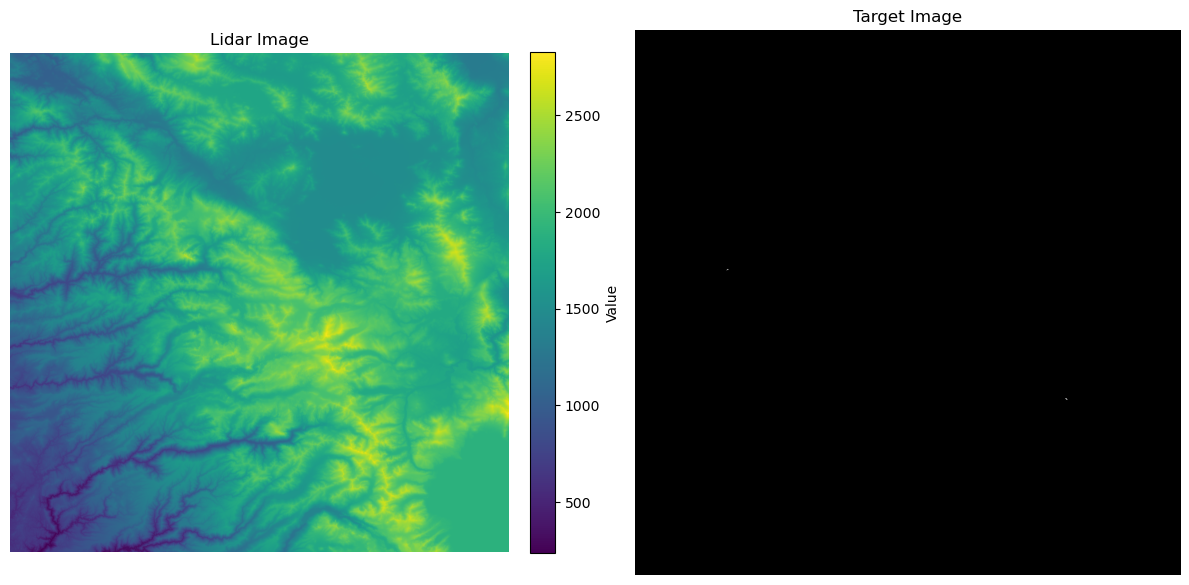

3


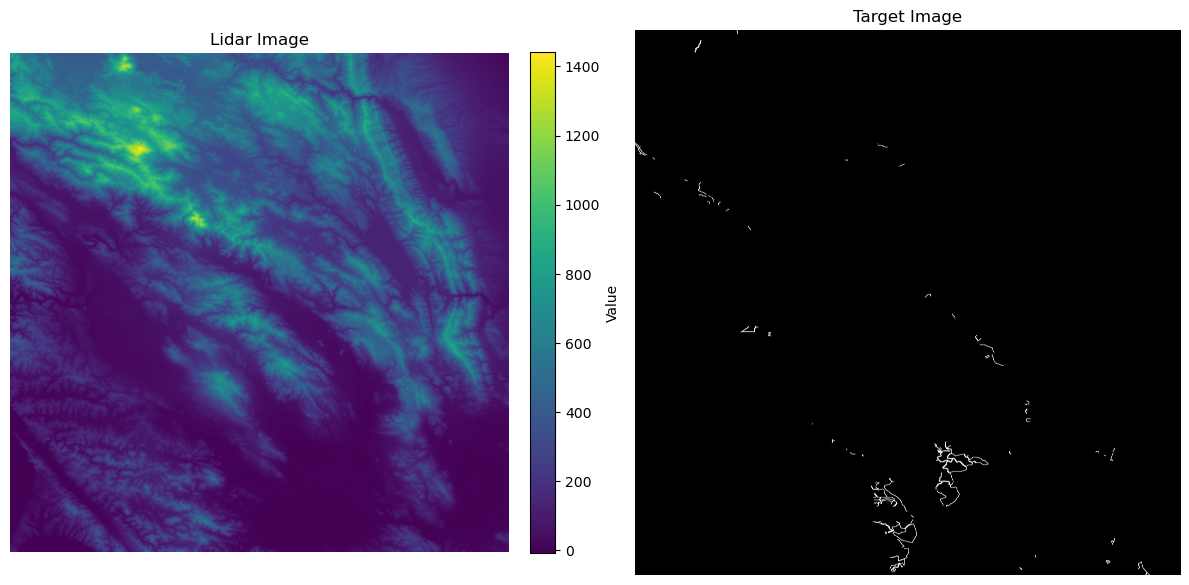

4


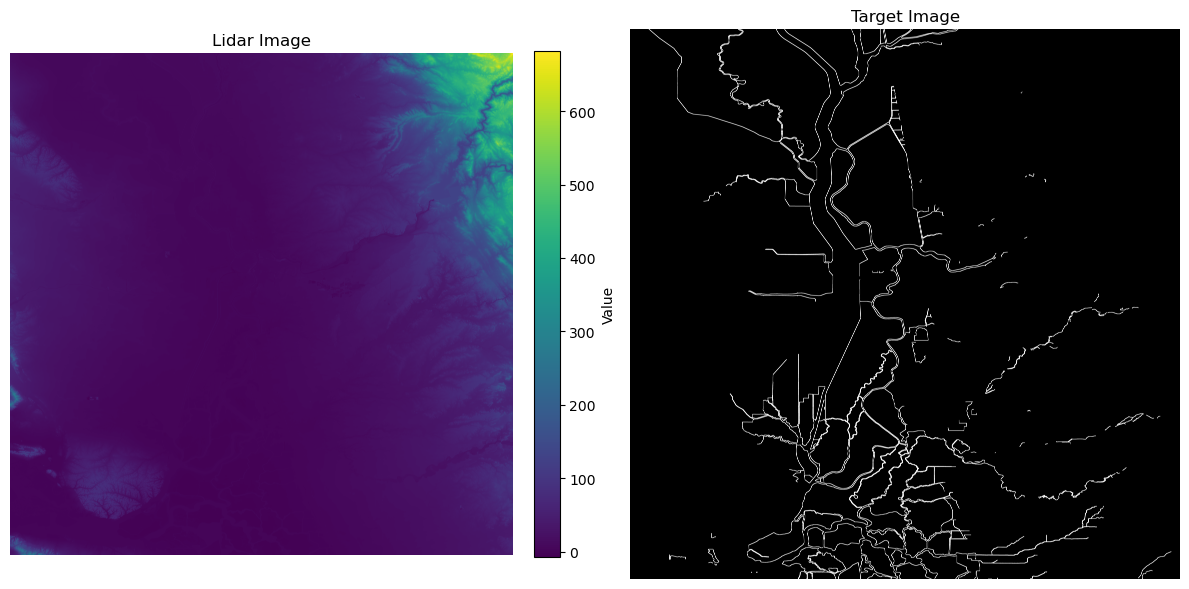

In [13]:
for ix in range(len(lidar_images_arr)):
    print(ix)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the first image
    im = axes[0].imshow(lidar_images_arr[ix], cmap="viridis")
    axes[0].set_title("Lidar Image")
    axes[0].axis("off")

    cbar = fig.colorbar(
        im, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04
    )
    cbar.set_label("Value")  # Optional: Label for the colorbar

    # Plot the second image
    axes[1].imshow(
        targets_arr[ix], cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1
    )  # Explicitly map 0->white, 1->black
    axes[1].set_title("Target Image")
    axes[1].axis("off")  # Hide axes for cleaner visualization

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
lidar_images_arr.shape, targets_arr.shape

((5, 10812, 10812), (5, 10812, 10812))

In [15]:
find_splits(Z=10812, s=512, max_overlap_frac=0.1)[:5]

[(23, 44, 10808),
 (22, 22, 10802),
 (23, 45, 10786),
 (22, 23, 10781),
 (23, 46, 10764)]

In [16]:
img_13_dataset = SegmentationDataset(
    images=lidar_images_arr,
    targets=targets_arr,
    transform=None,
    split=True,
    patch_size=512,
    final_size=512,
    overlap=22,
)

len(img_13_dataset)  # 22*22 x 5

2420

In [17]:
img_13_dataset.remove_invalid_images()
len(img_13_dataset)

2420

In [18]:
img_13_dataset.remove_empty(keep_empty=0.2)
len(img_13_dataset)

619

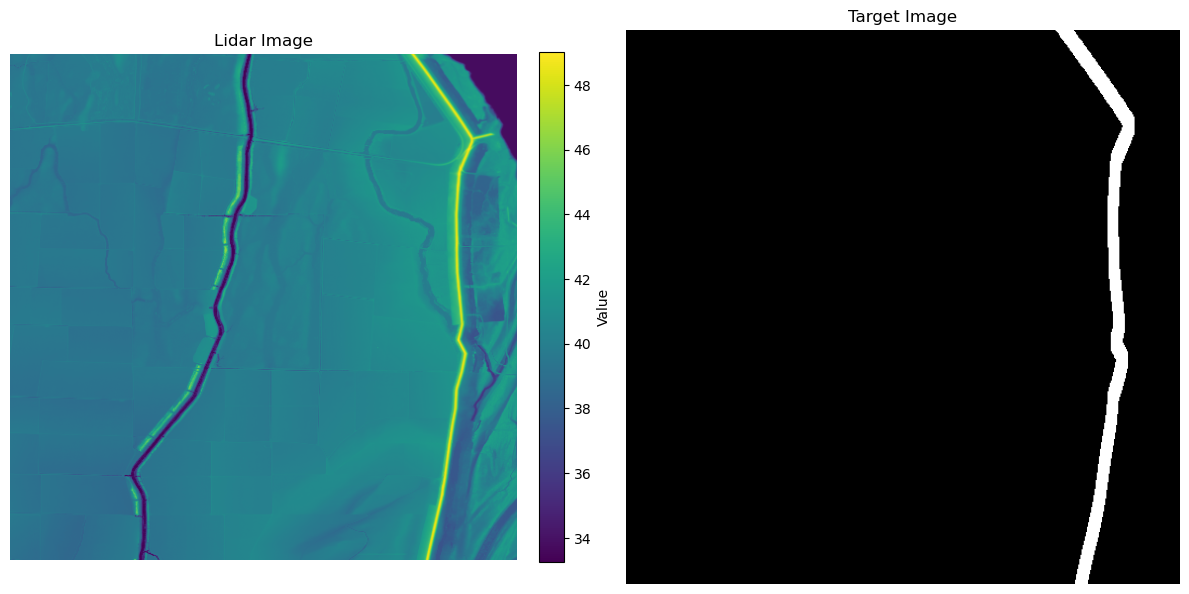

In [19]:
img_13_dataset.plot(37, figsize=(12, 6))

In [21]:
img_13_dataset.images[0].shape

torch.Size([1, 512, 512])

In [23]:
selected, special = interactive_labeling(img_13_dataset)

Label(value='')

Output()

Button(description='Yes (y)', style=ButtonStyle())

Button(description='Special (s)', style=ButtonStyle())

Button(description='No (n)', style=ButtonStyle())

Button(description='Quit (q)', style=ButtonStyle())

In [24]:
len(selected)

429

In [25]:
len(special)

247

In [27]:
# Convert selected indices to a set for efficient lookup
selected_set = set(selected)

# Find all indices that were NOT selected
all_indices = set(range(len(img_13_dataset.images)))
bad_indices = list(all_indices - selected_set)  # Get unselected indices

# Extract images and targets
good_imgs = np.array([img_13_dataset.images[i] for i in selected])
good_targets = np.array([img_13_dataset.targets[i] for i in selected])

special_imgs = np.array([img_13_dataset.images[i] for i in special])
special_targets = np.array([img_13_dataset.targets[i] for i in special])

bad_imgs = np.array([img_13_dataset.images[i] for i in bad_indices])
bad_targets = np.array([img_13_dataset.targets[i] for i in bad_indices])

good_imgs.shape, good_targets.shape

((429, 1, 512, 512), (429, 1, 512, 512))

In [28]:
# Define weights (higher for special images)
weights = torch.ones(len(good_imgs))  # Default weight = 1
special_indices_set = set(special)  # Convert to set for fast lookup

# Assign higher weight (e.g., 2x) to special images
for i, idx in enumerate(selected):
    if idx in special_indices_set:
        weights[i] = 2.0  # Increase weight

In [29]:
good_dataset = SegmentationDataset(
    images=good_imgs, targets=good_targets, transform=None, split=False
)

len(good_dataset)

429

In [30]:
good_dataset.weights = weights

In [31]:
better_dataset = SegmentationDataset(
    images=special_imgs, targets=special_targets, transform=None, split=False
)

len(better_dataset)

247

In [32]:
bad_dataset = SegmentationDataset(images=bad_imgs, targets=bad_targets, transform=None)

len(bad_dataset)

190

In [33]:
torch.save(
    good_dataset, "../data/processed/w3-4-based-datasets/good_dataset_13_512.pth"
)
torch.save(
    better_dataset, "../data/processed/w3-4-based-datasets/better_dataset_13_512.pth"
)
torch.save(bad_dataset, "../data/processed/w3-4-based-datasets/bad_dataset_13_512.pth")